In [1]:
import tifffile
import numpy as np
import skimage.io as io
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib
import pickle

import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context

In [57]:
sc.set_figure_params(format='png')
plt.rcParams.update({'font.size': 15})
sc.set_figure_params(scanpy=True, fontsize=25)

# Load and cluster transcriptomics data

In [7]:
our_dir = r'..\results\clustering_comparison'

exp1_bm_cells = pd.read_csv(r'..\results\expression\bm_abs_thre_expression_12_genes.csv')
exp1_uc_cells = pd.read_csv(r'..\results\expression\uc_abs_thre_expression_12_genes.csv')
exp2_uc_cells = pd.read_csv(r'..\results\expression\exp2_12genes.csv')
hch_cells = pd.read_csv(r'..\results\expression\hch_abs_thre_expression_16_genes.csv')

In [8]:
hch_cells_subframe = hch_cells.drop(columns=['MALAT1', 'MKI67', 'CXCR4', 'COL5A2'])

In [9]:
print(exp1_bm_cells.shape)
print(exp1_uc_cells.shape)
print(exp2_uc_cells.shape)
print(hch_cells_subframe.shape)

(237, 13)
(81, 13)
(40, 13)
(247, 13)


In [165]:
# Concatenate all dataframes
combined = pd.concat([exp1_bm_cells, exp1_uc_cells, exp2_uc_cells, hch_cells_subframe])

In [166]:
adata = sc.AnnData(combined.values[:,1:])
adata.var_names = combined.columns.tolist()[1:]
adata.obs['Cell'] = combined['Cell_ID'].tolist()

In [167]:
# Save raw data as anndata object
adata.raw = adata

In [168]:
sc.pp.normalize_total(adata, target_sum=1e6)

In [169]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

In [170]:
adata.obs['leiden'].value_counts()

0    150
1    106
2     80
3     76
4     71
5     65
6     57
Name: leiden, dtype: int64

In [92]:
# If saved clustering file already exist, load the file in this block
adata = sc.read_h5ad(filename='.\\count clustering.h5ad')

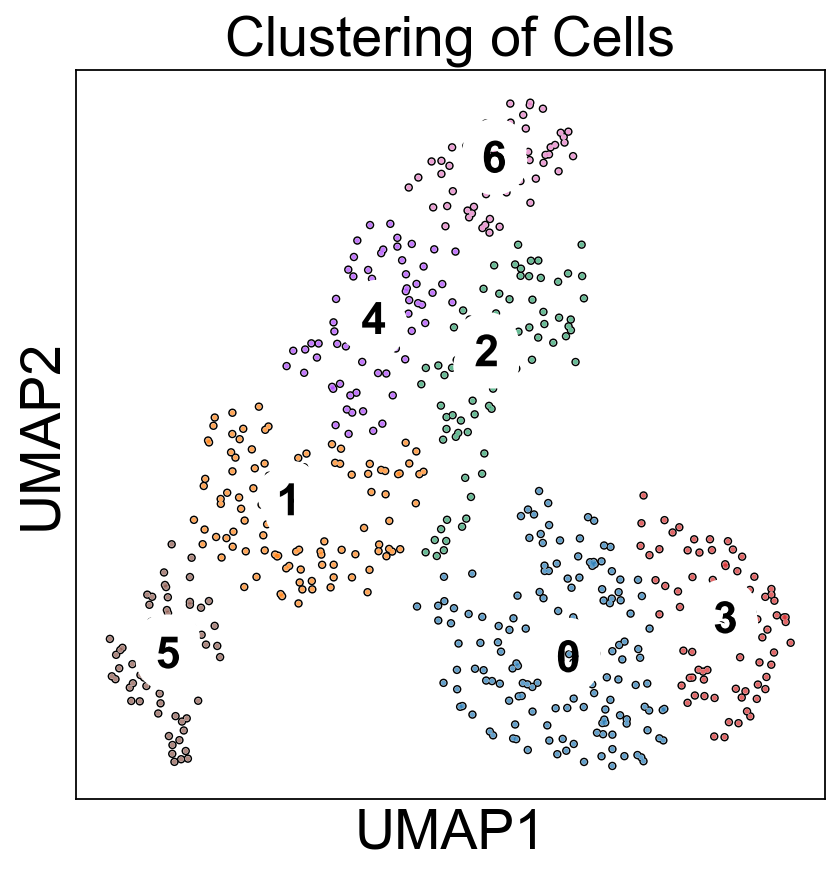

In [137]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color=['leiden'], size=20, 
               legend_loc='on data', add_outline=True, 
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Clustering of Cells', save=' count clustering.png')

In [172]:
cell_types = pd.Categorical(['HBM']*len(exp1_bm_cells['Cell_ID'].tolist())+['HUC']*len(exp1_uc_cells['Cell_ID'].tolist())+['HUC']*len(exp2_uc_cells['Cell_ID'].tolist())+['HCH']*len(hch_cells_subframe['Cell_ID'].tolist()),
                            ordered=True, categories=['HBM', 'HUC', 'HCH'])
adata.obs['cell_types'] = cell_types
adata.uns['cell_types_colors'] = ['#0000ff', '#ff0000', '#00ac00']

In [16]:
print("Number of BM cells: " + str(len(exp1_bm_cells['Cell_ID'].tolist())))
print("Number of UC cells: " + str(len(exp1_uc_cells['Cell_ID'].tolist())+len(exp2_uc_cells['Cell_ID'].tolist())))
print("Number of HCH cells: " + str(len(hch_cells_subframe['Cell_ID'].tolist())))

Number of BM cells: 237
Number of UC cells: 121
Number of HCH cells: 247


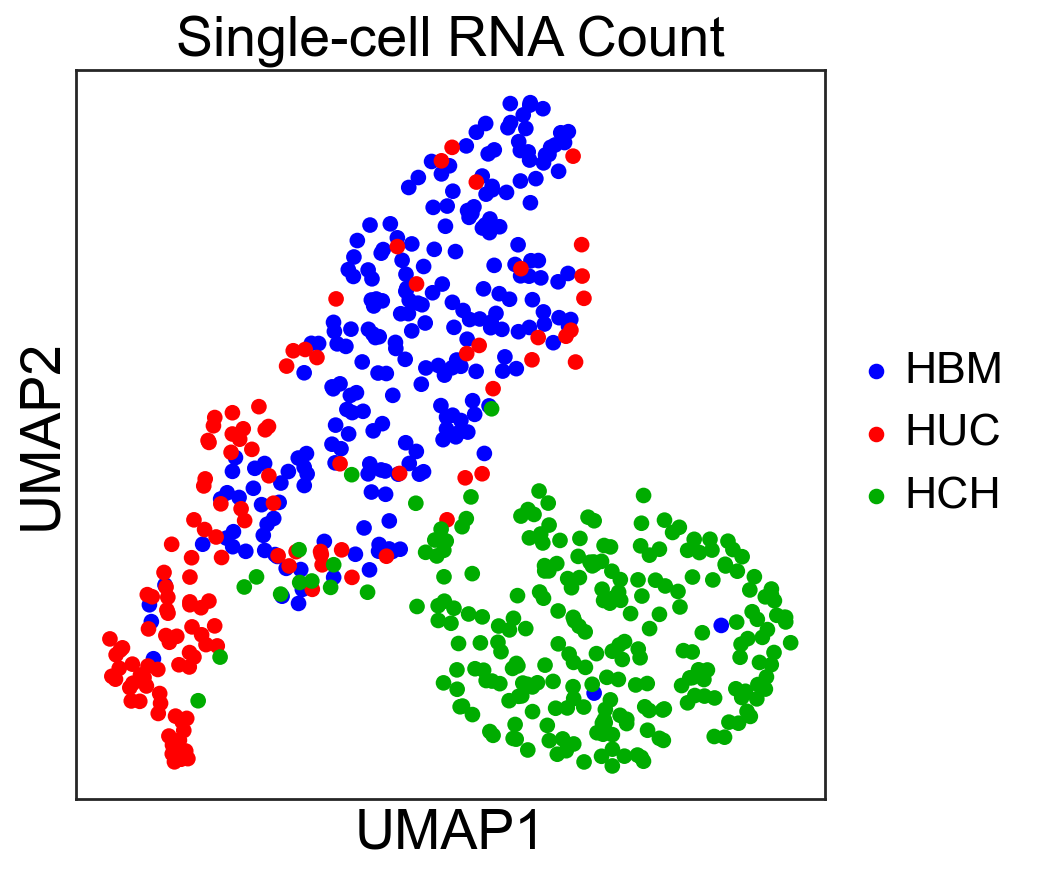

In [138]:
with rc_context({'figure.figsize': (6, 6), 'axes.edgecolor': '0.15', 'axes.linewidth': 1.25, 'axes.facecolor': '#FFFFFF'}):
    sc.pl.umap(adata, color=['cell_types'],
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Single-cell RNA Count', save='count.png')

In [18]:
sc.tl.rank_genes_groups(adata, groupby='leiden')

C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:418: RuntimeWarning: invalid value encountered in true_divide
  self.expm1_func(mean_rest) + 1e-9
C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:421: RuntimeWarning: divide by zero encountered in log2
  foldchanges[global_indices]


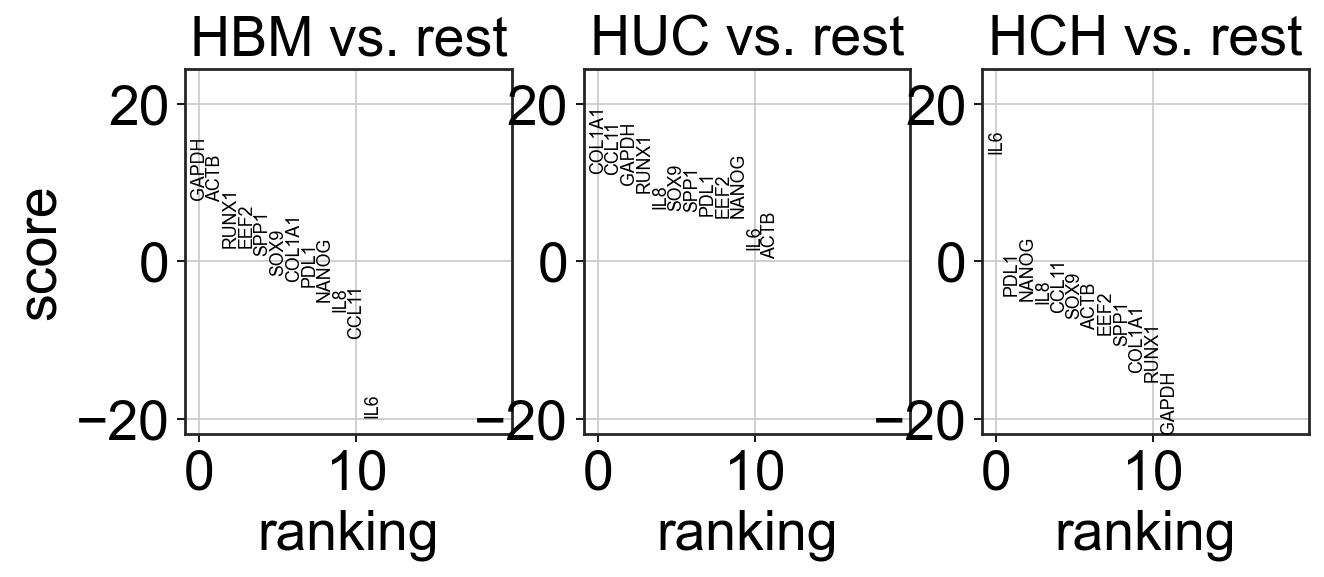

In [30]:
with rc_context({'figure.figsize': (3, 3), 'axes.edgecolor': '0.15', 'axes.linewidth': 1.25, 'axes.facecolor': '#FFFFFF', 'font.size':10}):
    sc.pl.rank_genes_groups(adata, save=' cell types gene enrichment.png')

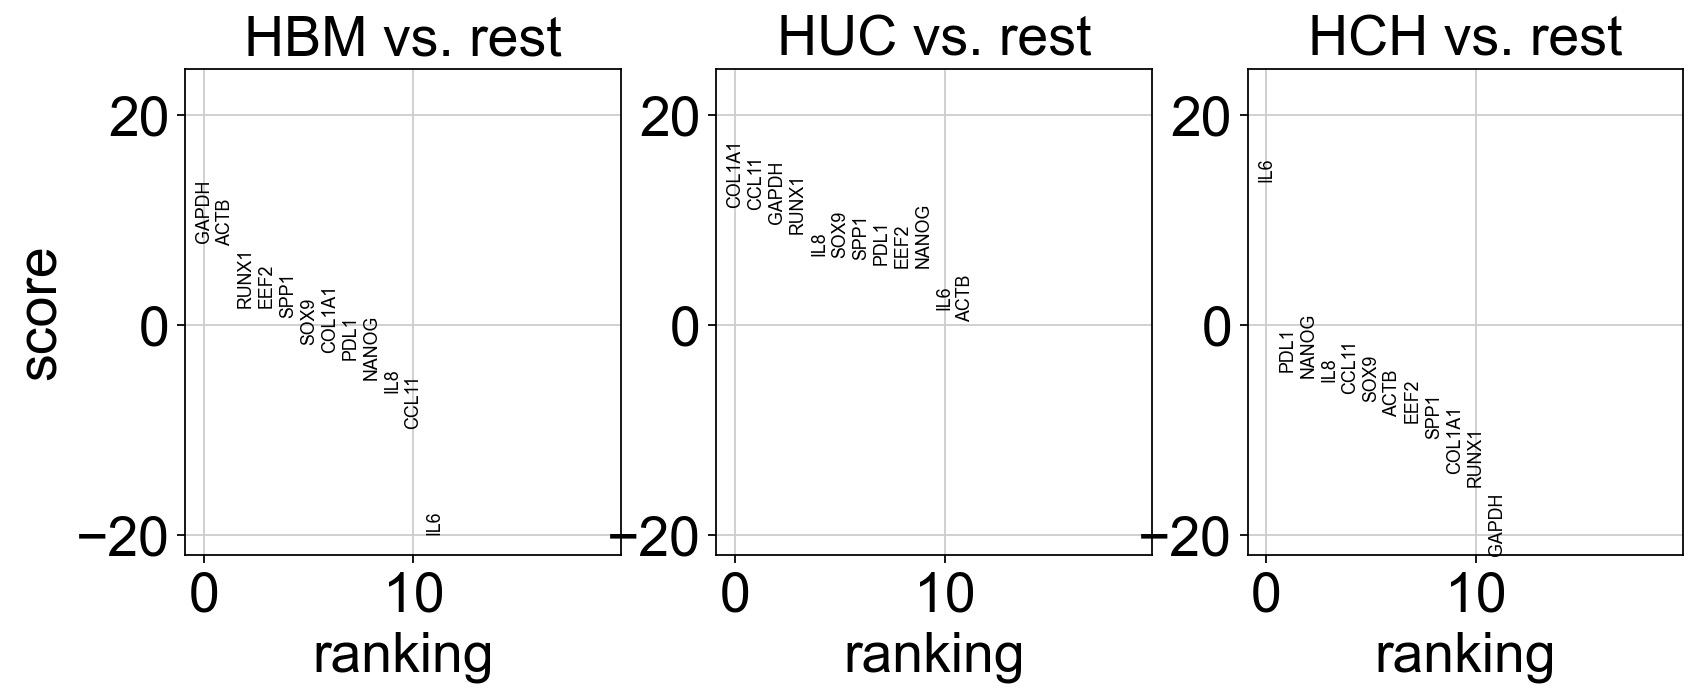

In [22]:
sc.pl.rank_genes_groups(adata, groupby='cell_types')

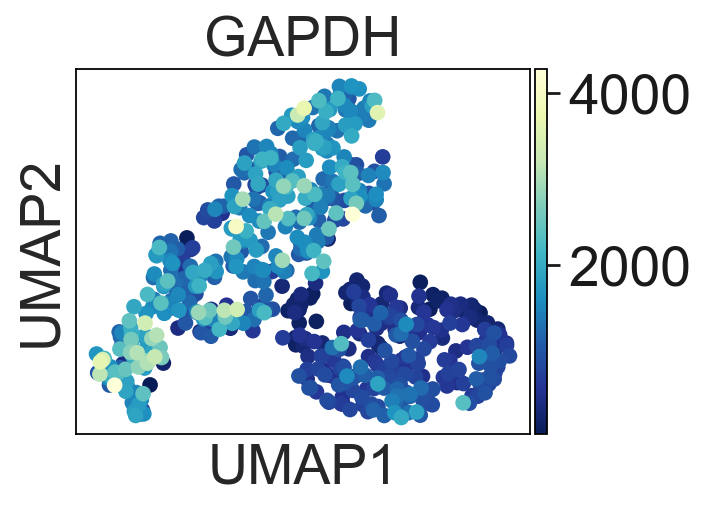

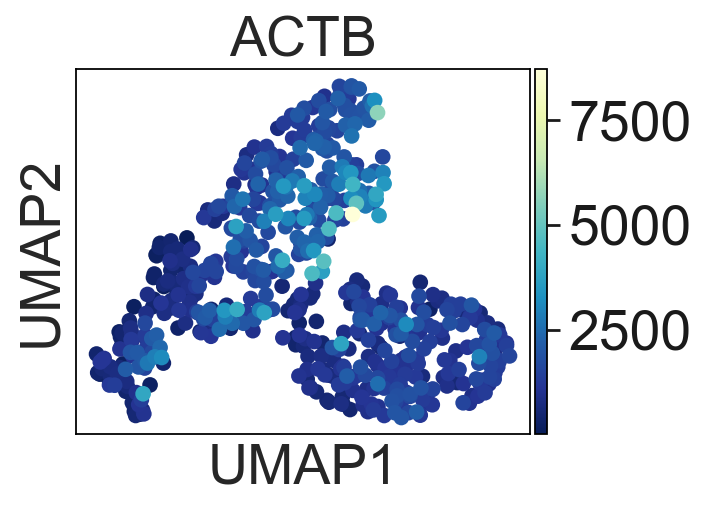

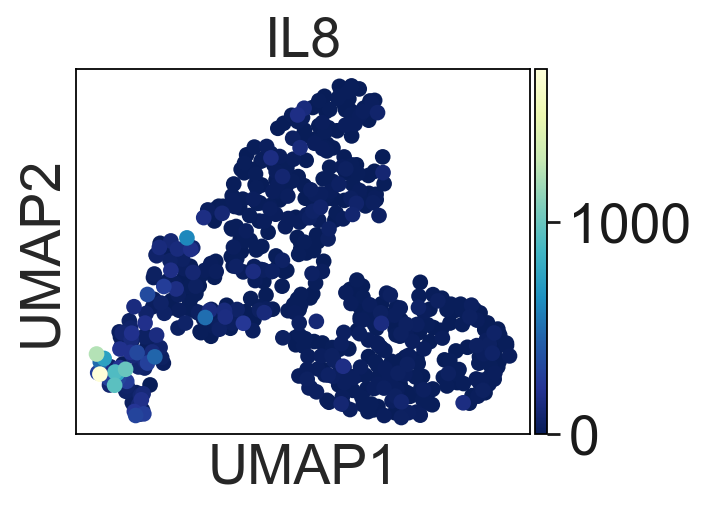

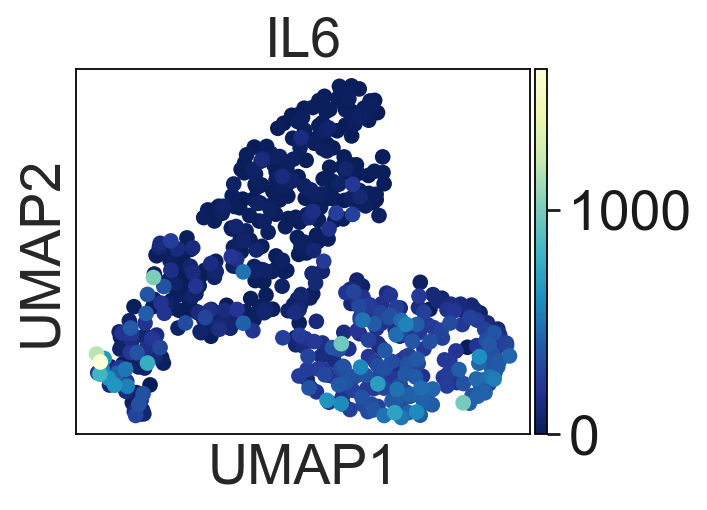

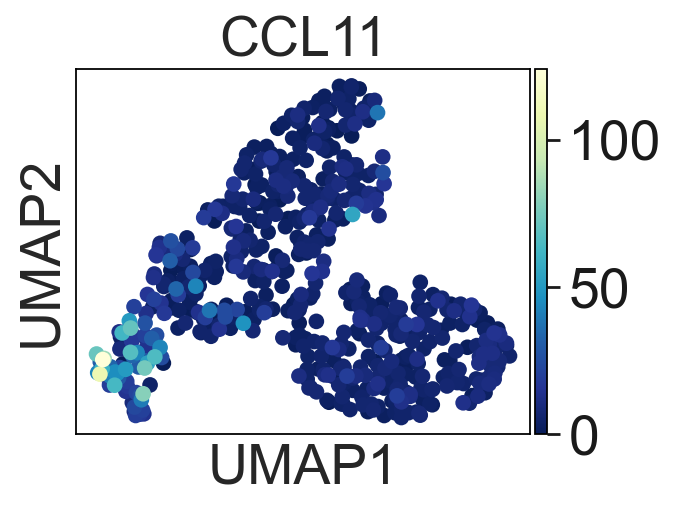

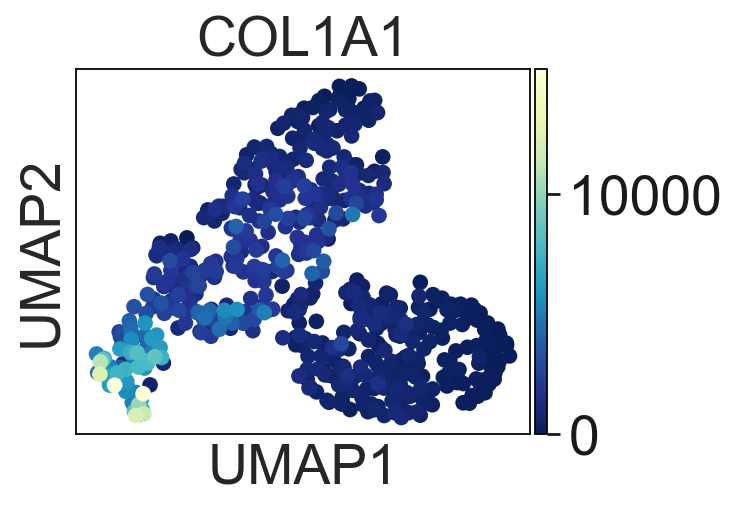

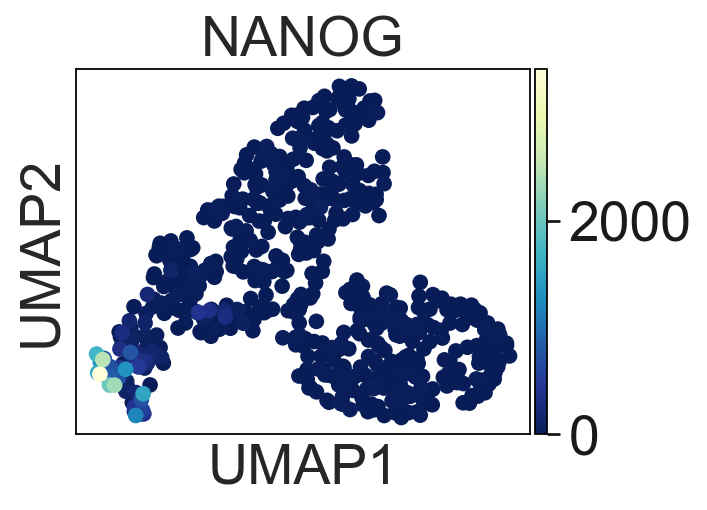

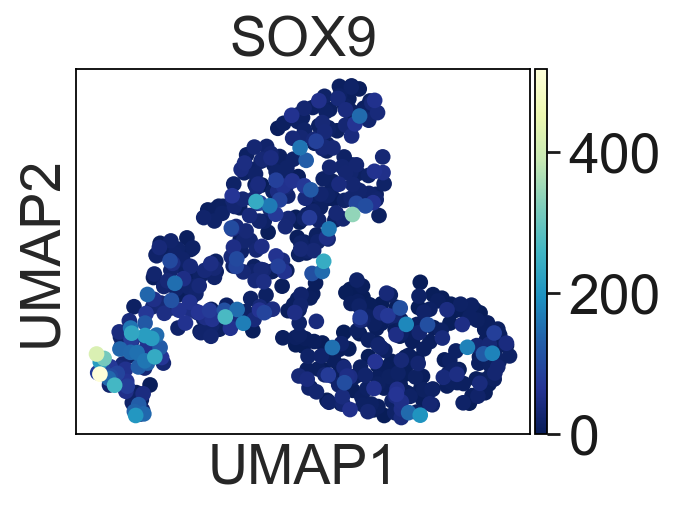

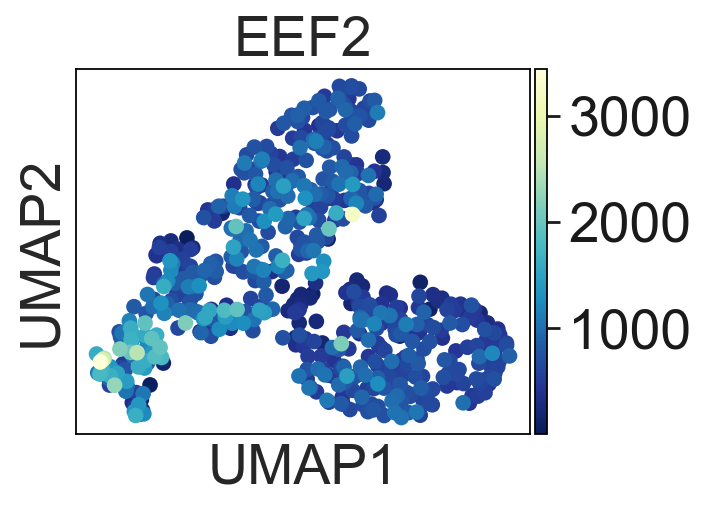

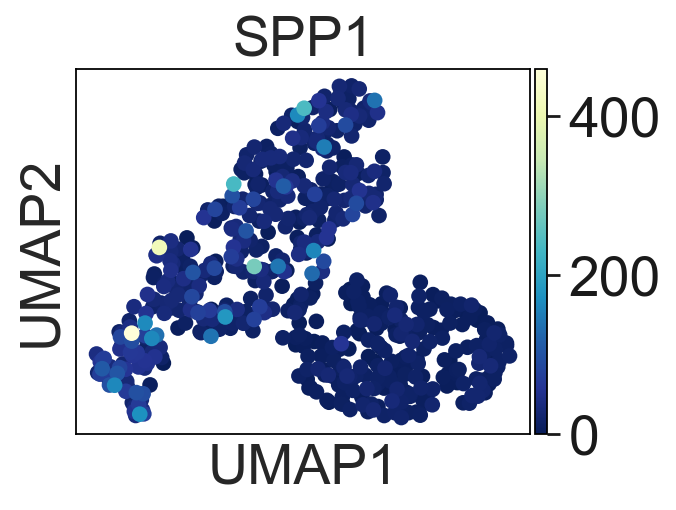

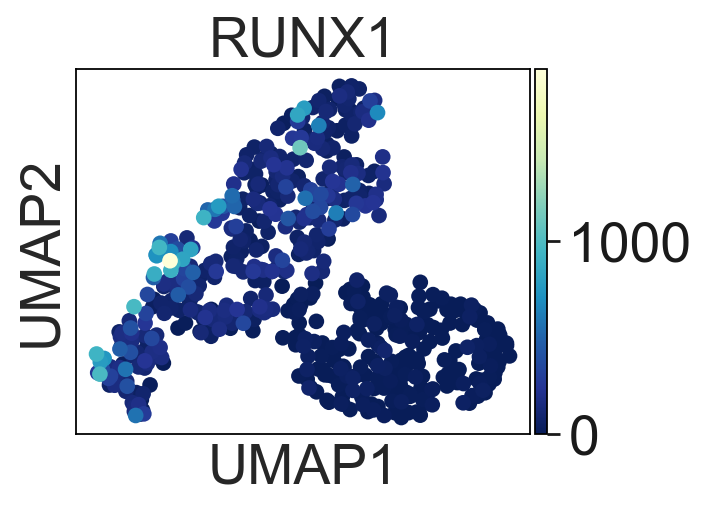

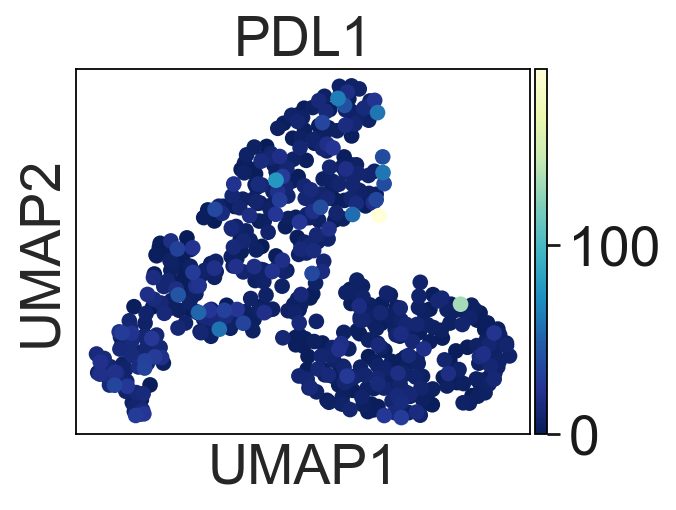

In [212]:
for item in adata.var_names.tolist():
    with rc_context({'figure.figsize': (4,3), 'font.size':8}):
        sc.pl.umap(adata, color=item, cmap='YlGnBu_r', save=' RNA enrichment '+item+'.png')

In [63]:
# Save cell type, cell id, and cell cluster into dataframe
count_sep_data = {'Cell ID': adata.obs['Cell'].tolist(),
                  'Cluster': adata.obs['leiden'].tolist(),
                  'Cell types': adata.obs['cell_types'].tolist()
                 }
count_set_data = pd.DataFrame(count_sep_data)

In [66]:
with open('.\\expression clustering v. cell type.pkl', 'wb') as f:
    pickle.dump(count_sep_data, f)

### Visualize edge secretors on umap

In [128]:
edge_cell_id = pd.read_csv(r'.\\cytokine_figures\\edge_secretors.csv')
edge_cell_id

,IL8,CCL11,Both
0,exp1_bm_030_2,exp1_bm_007_1,exp1_bm_005_4
1,exp1_bm_057_1,exp1_bm_013_1,exp1_bm_008_1
2,exp1_uc_011_2,exp1_bm_021_3,exp1_bm_025_3
3,NaN,exp1_bm_022_1,exp1_bm_032_1
4,NaN,exp1_bm_042_2,exp1_bm_036_1
5,NaN,exp1_bm_074_1,exp1_bm_036_2
6,NaN,exp1_bm_091_3,exp1_bm_072_1
7,NaN,exp1_uc_012_1,exp1_uc_001_1
8,NaN,exp1_uc_013_1,exp1_uc_003_2
9,NaN,exp1_uc_016_1,exp1_uc_008_1


In [129]:
edge_cells = edge_cell_id['IL8'].tolist() + edge_cell_id['CCL11'].tolist() + edge_cell_id['Both'].tolist()
edge_indicator = []
for cell in adata.obs['Cell'].tolist():
    if cell in edge_cells:
        edge_indicator.append('Edge')
    else:
        edge_indicator.append('Non-edge')

In [130]:
edge_types = pd.Categorical(edge_indicator, ordered=True, categories=['Edge','Non-edge'])
adata.obs['edge_types'] = edge_types
adata.uns['edge_types_colors'] = ['#ee8f9c', '#729ed7']

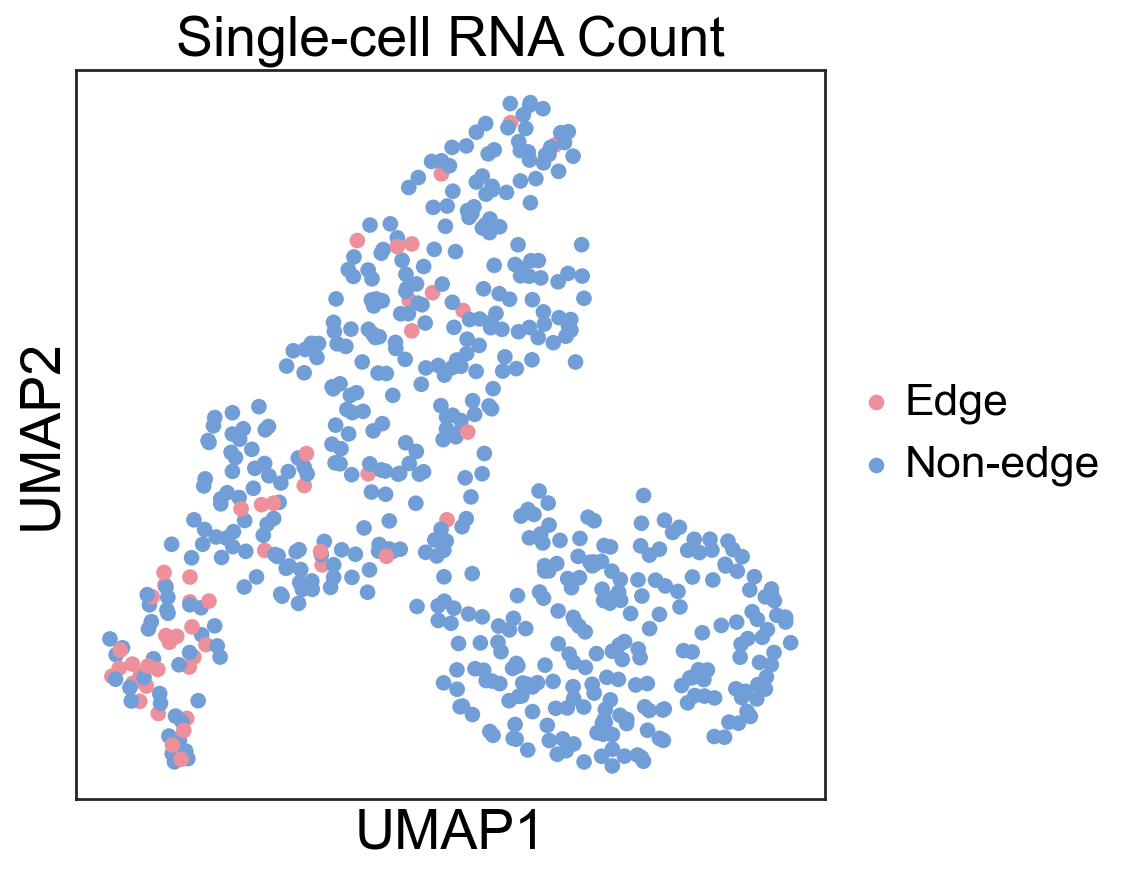

In [139]:
with rc_context({'figure.figsize': (6, 6), 'axes.edgecolor': '0.15', 'axes.linewidth': 1.25, 'axes.facecolor': '#FFFFFF'}):
    sc.pl.umap(adata, color=['edge_types'],
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Single-cell RNA Count', save='edge in count.png')

## Statistical analysis of dot counts


In [42]:
adata

AnnData object with n_obs × n_vars = 605 × 12
    obs: 'Cell', 'leiden', 'cell_types'
    uns: 'cell_types_colors', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances'

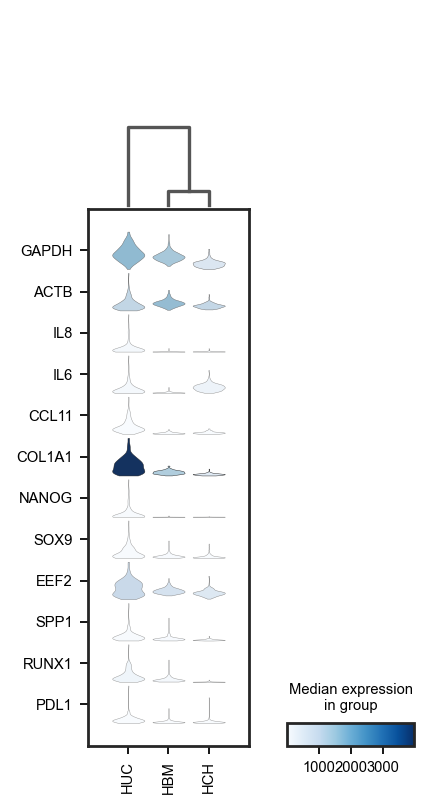

In [93]:
with rc_context({'figure.figsize': (12, 12), 'axes.edgecolor': '0.15', 'axes.linewidth': 1.25, 'axes.facecolor': '#FFFFFF', 'font.size':8}):
    sc.pl.stacked_violin(adata,adata.var_names.tolist(),groupby='cell_types',dendrogram=True,swap_axes=True,)

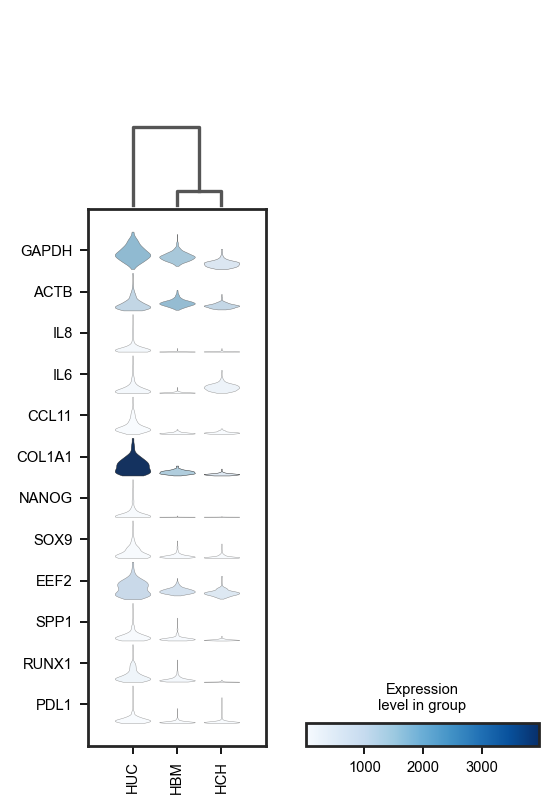

In [101]:
with rc_context({'figure.figsize': (12, 12), 'axes.edgecolor': '0.15', 'axes.linewidth': 1.25, 'axes.facecolor': '#FFFFFF', 'font.size':8}):
    fig = sc.pl.StackedViolin(adata, adata.var_names.tolist(), groupby='cell_types', dendrogram=True, swap_axes=True)
    fig.swap_axes(swap_axes=True)
    fig.add_dendrogram()
    fig.legend(width=2.5)
    fig.make_figure()
    plt.savefig('.\\figures\\sc rna count clustering\\dot count violin.png')
    plt.show()

In [105]:
temp = adata.X
temp = (temp - np.mean(temp, axis=0))/np.std(temp, axis=0)

In [112]:
new_adata = sc.AnnData(temp)
new_adata.var_names = adata.var_names.tolist()
new_adata.obs['Cell'] = adata.obs['Cell']

new_adata.obs['cell_types'] = adata.obs['cell_types']
new_adata.uns['cell_types_colors'] = adata.uns['cell_types_colors']

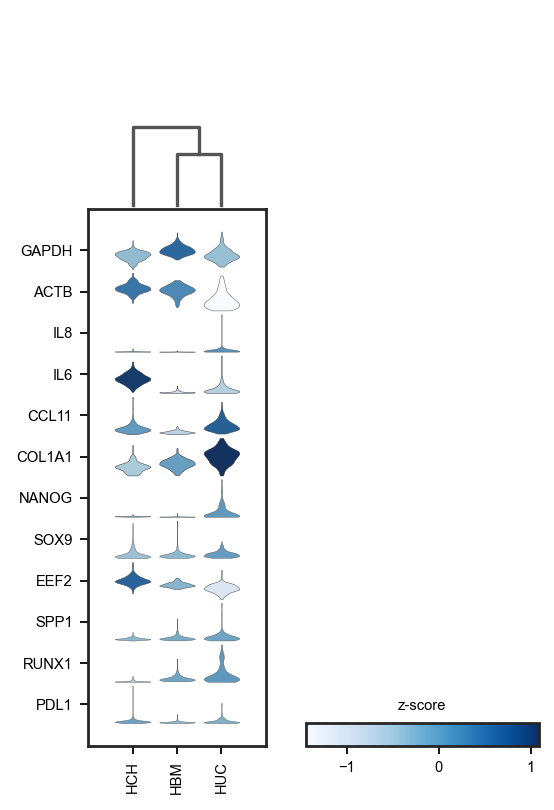

In [118]:
with rc_context({'figure.figsize': (12, 12), 'axes.edgecolor': '0.15', 'axes.linewidth': 1.25, 'axes.facecolor': '#FFFFFF', 'font.size':8}):
    fig = sc.pl.StackedViolin(new_adata, new_adata.var_names.tolist(), groupby='cell_types', dendrogram=True, swap_axes=True)
    fig.swap_axes(swap_axes=True)
    fig.add_dendrogram()
    fig.legend(title='z-score', width=2.5)
    fig.make_figure()
    plt.savefig('.\\figures\\sc rna count clustering\\z-score violin.png')
    plt.show()

In [213]:
save_name = os.path.join('count clustering.h5ad')
adata.write(filename=save_name)

# Load correlation data

In [19]:
corr_in_dir1 = r'..\results\HBM\patches'
corr_in_dir2 = r'..\results\HUC\patches'
# corr_in_dir3 = r'..\results\HUC\patches'
corr_in_dir4 = r'..\results\HCH\patches'

In [38]:
bm_corr_l = []
exp1_uc_corr_l = []
exp2_uc_corr_l = []
hch_corr_l = []
fn_l1 = os.listdir(corr_in_dir1)
fn_l1.sort()
fn_l2 = os.listdir(corr_in_dir2)
fn_l2.sort()
fn_l3 = os.listdir(corr_in_dir3)
fn_l3.sort()
fn_l4 = os.listdir(corr_in_dir4)
fn_l4.sort()

for fn in fn_l1[1:]:
    if fn.endswith('.pkl') and (not fn.startswith('z_')):
        temp = pd.read_pickle(os.path.join(corr_in_dir1, fn))
        bm_corr_l.append(temp['correlation'])
for fn in fn_l2:
    if fn.endswith('.pkl') and (not fn.startswith('z_')):
        temp = pd.read_pickle(os.path.join(corr_in_dir2, fn))
        exp1_uc_corr_l.append(temp['correlation'])
for fn in fn_l3:
    if fn.endswith('.pkl') and (not fn.startswith('z_')):
        temp = pd.read_pickle(os.path.join(corr_in_dir3, fn))
        exp2_uc_corr_l.append(temp['correlation'])
for fn in fn_l4:
    if fn.endswith('.pkl') and (not fn.startswith('z_')):
        temp = pd.read_pickle(os.path.join(corr_in_dir4, fn))
        hch_corr_l.append(temp['correlation'])

In [39]:
print(len(bm_corr_l))
print(len(exp1_uc_corr_l))
print(len(exp2_uc_corr_l))
print(len(hch_corr_l))

237
81
40
247


In [40]:
def row_col_value(df, pairs):
    corr = []
    for r_c in pairs:
        r,c = r_c.split('_')
        corr.append(df.loc[r, c])
        if not(df.loc[r,c] == df.loc[r,c]):
            print(df)
    return np.array(corr)

In [41]:
adata.var_names

Index(['GAPDH', 'ACTB', 'IL8', 'IL6', 'CCL11', 'COL1A1', 'NANOG', 'SOX9',
       'EEF2', 'SPP1', 'RUNX1', 'PDL1'],
      dtype='object')

In [42]:
# Find marker pairs
markers = adata.var_names.tolist()
pairs = []
for i in range(len(markers)):
    for j in range(len(markers)):
        if not ((markers[i]+'_'+markers[j] in pairs) or (markers[j]+'_'+markers[i] in pairs)):
            pairs.append(markers[i]+'_'+markers[j])

In [43]:
bm_corr_exploded_l = []
exp1_uc_corr_exploded_l = []
exp2_uc_corr_exploded_l = []
hch_corr_exploded_l = []
for df in bm_corr_l:
    bm_corr_exploded_l.append(row_col_value(df, pairs))
for df in exp1_uc_corr_l:
    exp1_uc_corr_exploded_l.append(row_col_value(df, pairs))
for df in exp2_uc_corr_l:
    exp2_uc_corr_exploded_l.append(row_col_value(df, pairs))
for df in hch_corr_l:
    hch_corr_exploded_l.append(row_col_value(df, pairs))
bm_corrs = np.vstack(bm_corr_exploded_l)
exp1_uc_corrs = np.vstack(exp1_uc_corr_exploded_l)
exp2_uc_corrs = np.vstack(exp2_uc_corr_exploded_l)
hch_corrs = np.vstack(hch_corr_exploded_l)

In [44]:
print(bm_corrs.shape)
print(exp1_uc_corrs.shape)
print(exp2_uc_corrs.shape)
print(hch_corrs.shape)

(237, 78)
(81, 78)
(40, 78)
(247, 78)


In [45]:
len(adata.obs['Cell'].tolist())

605

In [46]:
corr_adata

AnnData object with n_obs × n_vars = 1210 × 78

In [47]:
corr_adata = sc.AnnData(np.concatenate((bm_corrs, exp1_uc_corrs, exp2_uc_corrs, hch_corrs)))
corr_adata.obs['Cell'] = adata.obs['Cell'].tolist()
corr_adata.var_names = pairs
corr_adata.obs['cell_types'] = cell_types
corr_adata.uns['cell_types_colors'] = ['#0000ff', '#ff0000', '#00ac00']

In [48]:
corr_adata.raw = corr_adata

In [49]:
sc.pp.pca(corr_adata)

In [50]:
sc.pp.neighbors(corr_adata)
sc.tl.umap(corr_adata)
sc.tl.leiden(corr_adata, resolution=1)

In [3]:
# Load saved h5ad file here
corr_adata = sc.read_h5ad(filename='.\\patch correlation clustering.h5ad')

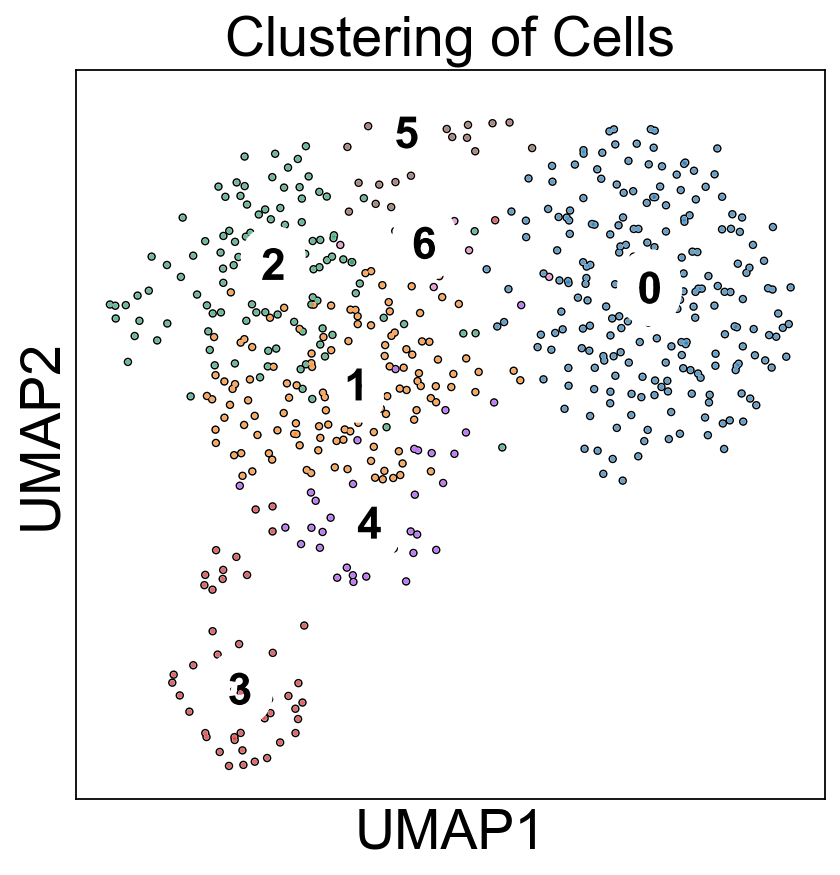

In [134]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(corr_adata, color=['leiden'], size=20, 
               legend_loc='on data', add_outline=True, 
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Clustering of Cells', save=' correlation clustering.png')

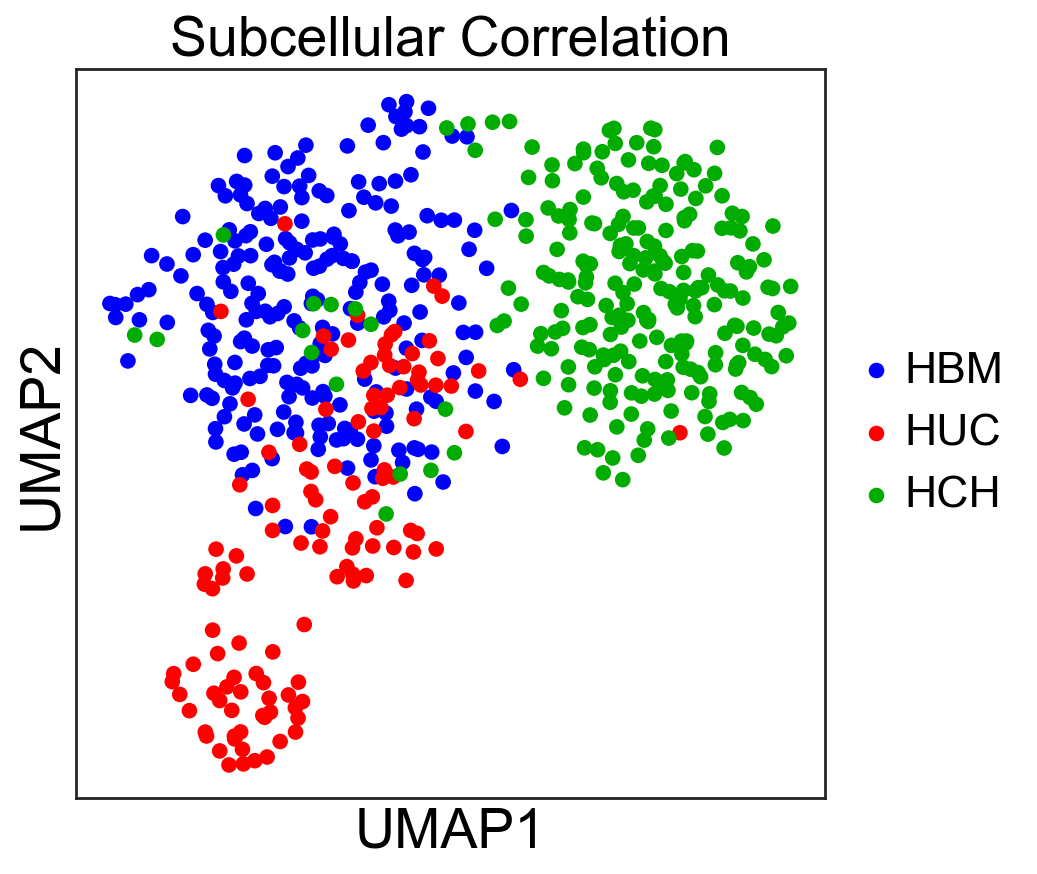

In [135]:
with rc_context({'figure.figsize': (6, 6), 'axes.edgecolor': '0.15', 'axes.linewidth': 1.25, 'axes.facecolor': '#FFFFFF'}):
    sc.pl.umap(corr_adata, color=['cell_types'],
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Subcellular Correlation', save='correlation.png')

In [34]:
sc.tl.rank_genes_groups(corr_adata, groupby='leiden')

C:\Users\zfang38\Anaconda3\envs\scenv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


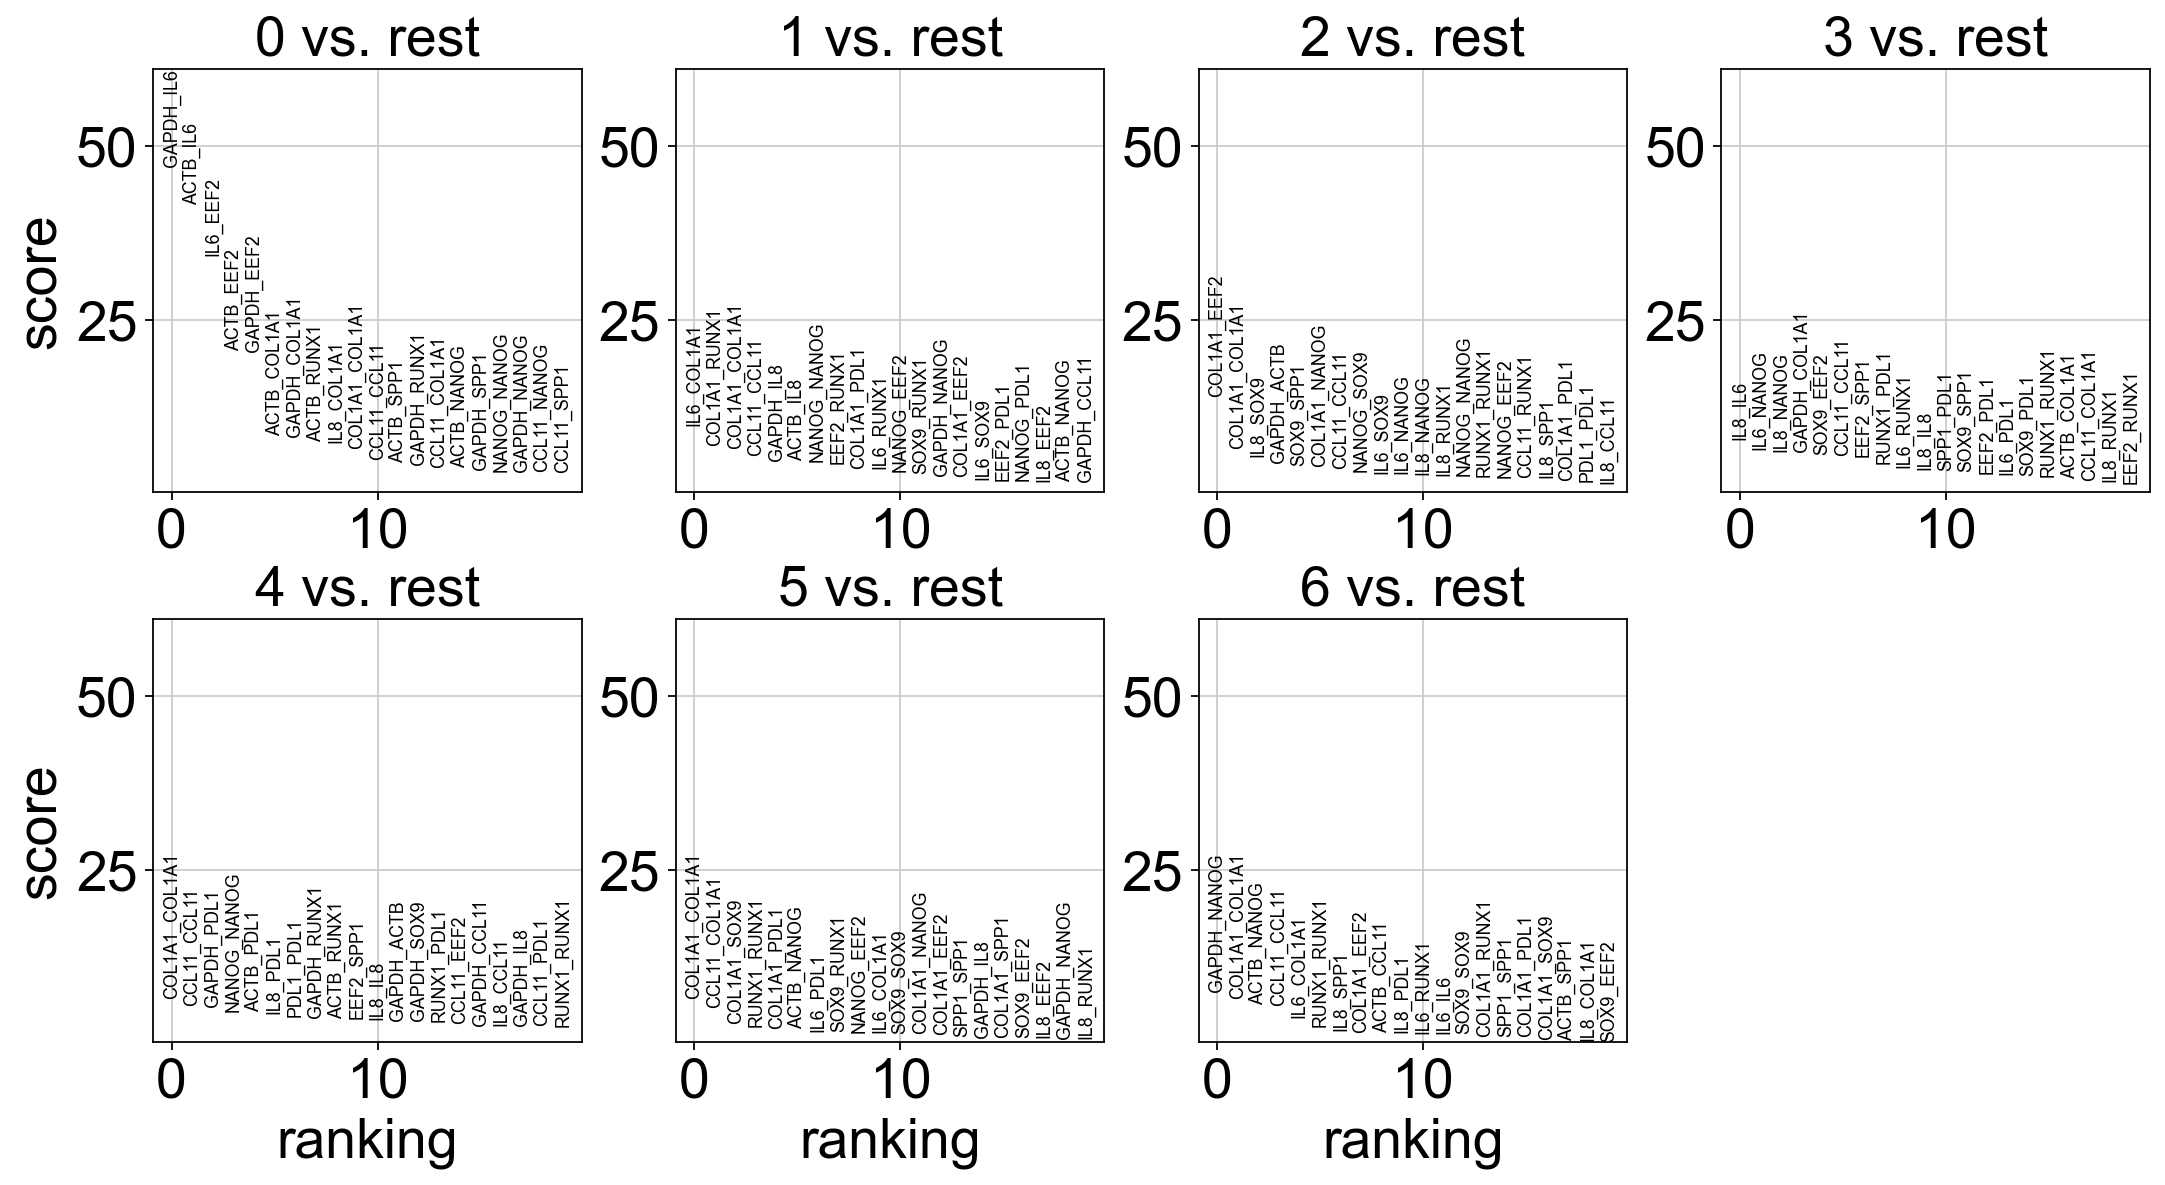

In [35]:
sc.pl.rank_genes_groups(corr_adata)

In [36]:
sc.tl.rank_genes_groups(corr_adata, groupby='cell_types')

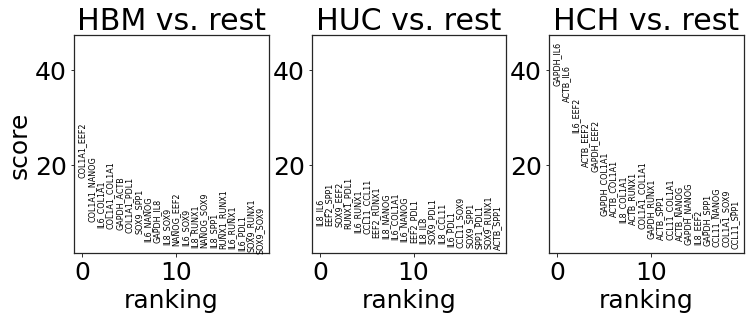

In [10]:
with rc_context({'figure.figsize': (4,4), 'axes.edgecolor': '0.15', 'axes.linewidth': 1.25, 'axes.facecolor': '#FFFFFF', 'font.size':25, 'figure.subplot.wspace':0.2}):
    sc.pl.rank_genes_groups(corr_adata, save=' cell types marker correlation feature.png')

In [70]:
# Save clustering and cell type groups
corr_sep_data = {'Cell ID': corr_adata.obs['Cell'].tolist(),
                  'Cluster': corr_adata.obs['leiden'].tolist(),
                  'Cell types': corr_adata.obs['cell_types'].tolist()
                 }
corr_set_data = pd.DataFrame(corr_sep_data)

In [71]:
with open('.\\correlation clustering v. cell type.pkl', 'wb') as f:
    pickle.dump(corr_sep_data, f)

### Edge type plotting

In [122]:
edge_types = pd.Categorical(edge_indicator, ordered=True, categories=['Edge','Non-edge'])
corr_adata.obs['edge_types'] = edge_types
corr_adata.uns['edge_types_colors'] = ['#ee8f9c', '#729ed7']

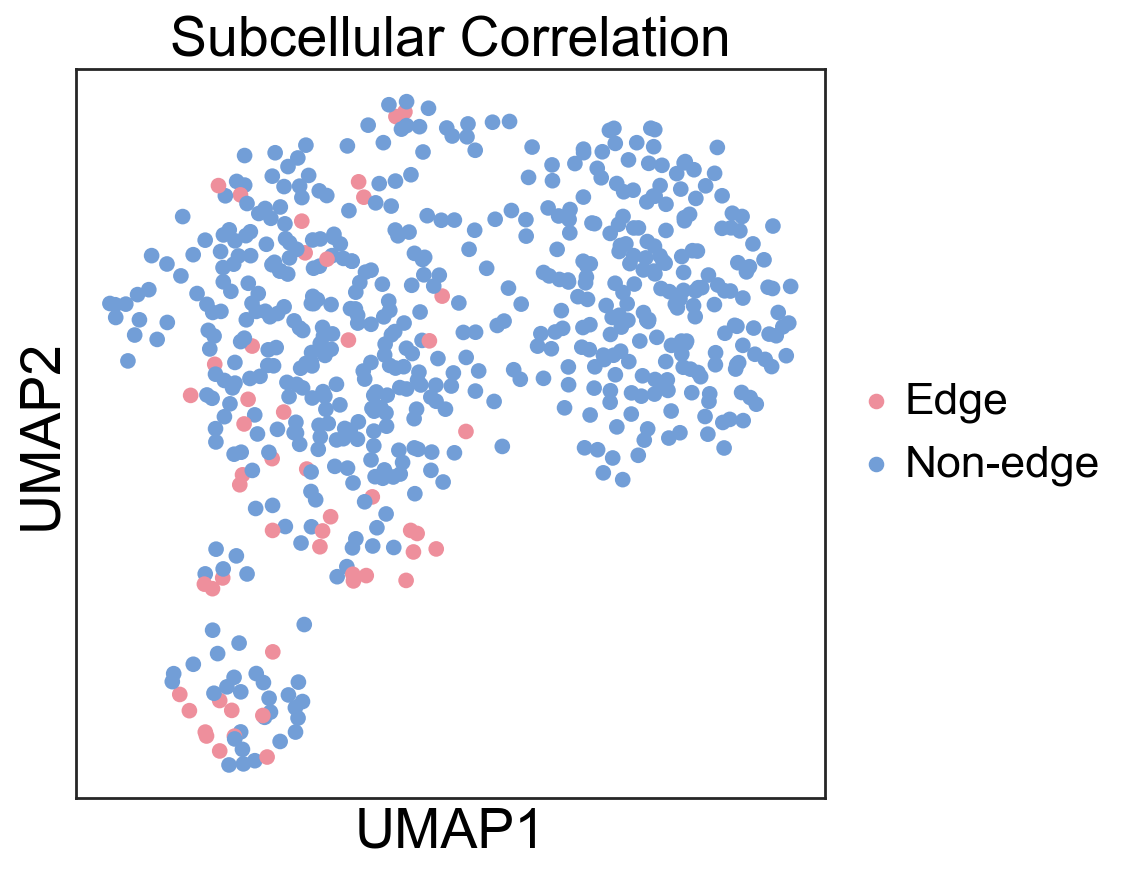

In [140]:
with rc_context({'figure.figsize': (6, 6), 'axes.edgecolor': '0.15', 'axes.linewidth': 1.25, 'axes.facecolor': '#FFFFFF'}):
    sc.pl.umap(corr_adata, color=['edge_types'],
               legend_fontsize=20, legend_fontoutline=20, 
               frameon=True,  title='Subcellular Correlation', save='edge on correlation.png')

## Combined clustering separation

In [57]:
expression_clusters = adata.obs['leiden'].tolist()
spatial_clusters = corr_adata.obs['leiden'].tolist()

In [58]:
combined_cluster = list(zip(expression_clusters, spatial_clusters))

In [59]:
combined_stats = np.array(combined_cluster).astype('float')

In [60]:
combined_stats

array([[4., 2.],
       [1., 2.],
       [0., 6.],
       ...,
       [0., 0.],
       [0., 0.],
       [3., 0.]])

In [61]:
l = []
for e in np.unique(combined_stats[:,0]):
    l.append(combined_stats[combined_stats[:,0]==0,:][:,1])

In [94]:
true_labels = ['HBM']*237+['HUC']*121+['HCH']*247

In [96]:
combined_stats.shape

(605, 2)

In [97]:
x = pd.DataFrame(combined_stats, columns=['expression clusters', 'correlation clusters'])
x['Cell Type'] = true_labels

In [131]:
x_counts = np.zeros((7,7))
true_label_counts = np.zeros((7,7,3))
expression_cluster_l = ['0', '1', '2', '3', '4', '5', '6']
correlation_cluster_l = ['0', '1', '2', '3', '4', '5', '6']
# x_counts = pd.DataFrame(x_counts, columns=expression_cluster_l, index=correlation_cluster_l)
for i in range(x.shape[0]):
    expression_cluster = x.iloc[i]['expression clusters']
    correlation_cluster = x.iloc[i]['correlation clusters']
    x_counts[int(expression_cluster), int(correlation_cluster)] += 1
    if x.iloc[i]['Cell Type'] == 'HBM':
        true_label_counts[int(expression_cluster), int(correlation_cluster), 0] += 1
    elif x.iloc[i]['Cell Type'] == 'HUC':
        true_label_counts[int(expression_cluster), int(correlation_cluster), 1] += 1
    else:
        true_label_counts[int(expression_cluster), int(correlation_cluster), 2] += 1

In [132]:
x_counts_df = pd.DataFrame(x_counts, columns=correlation_cluster_l, index=expression_cluster_l)

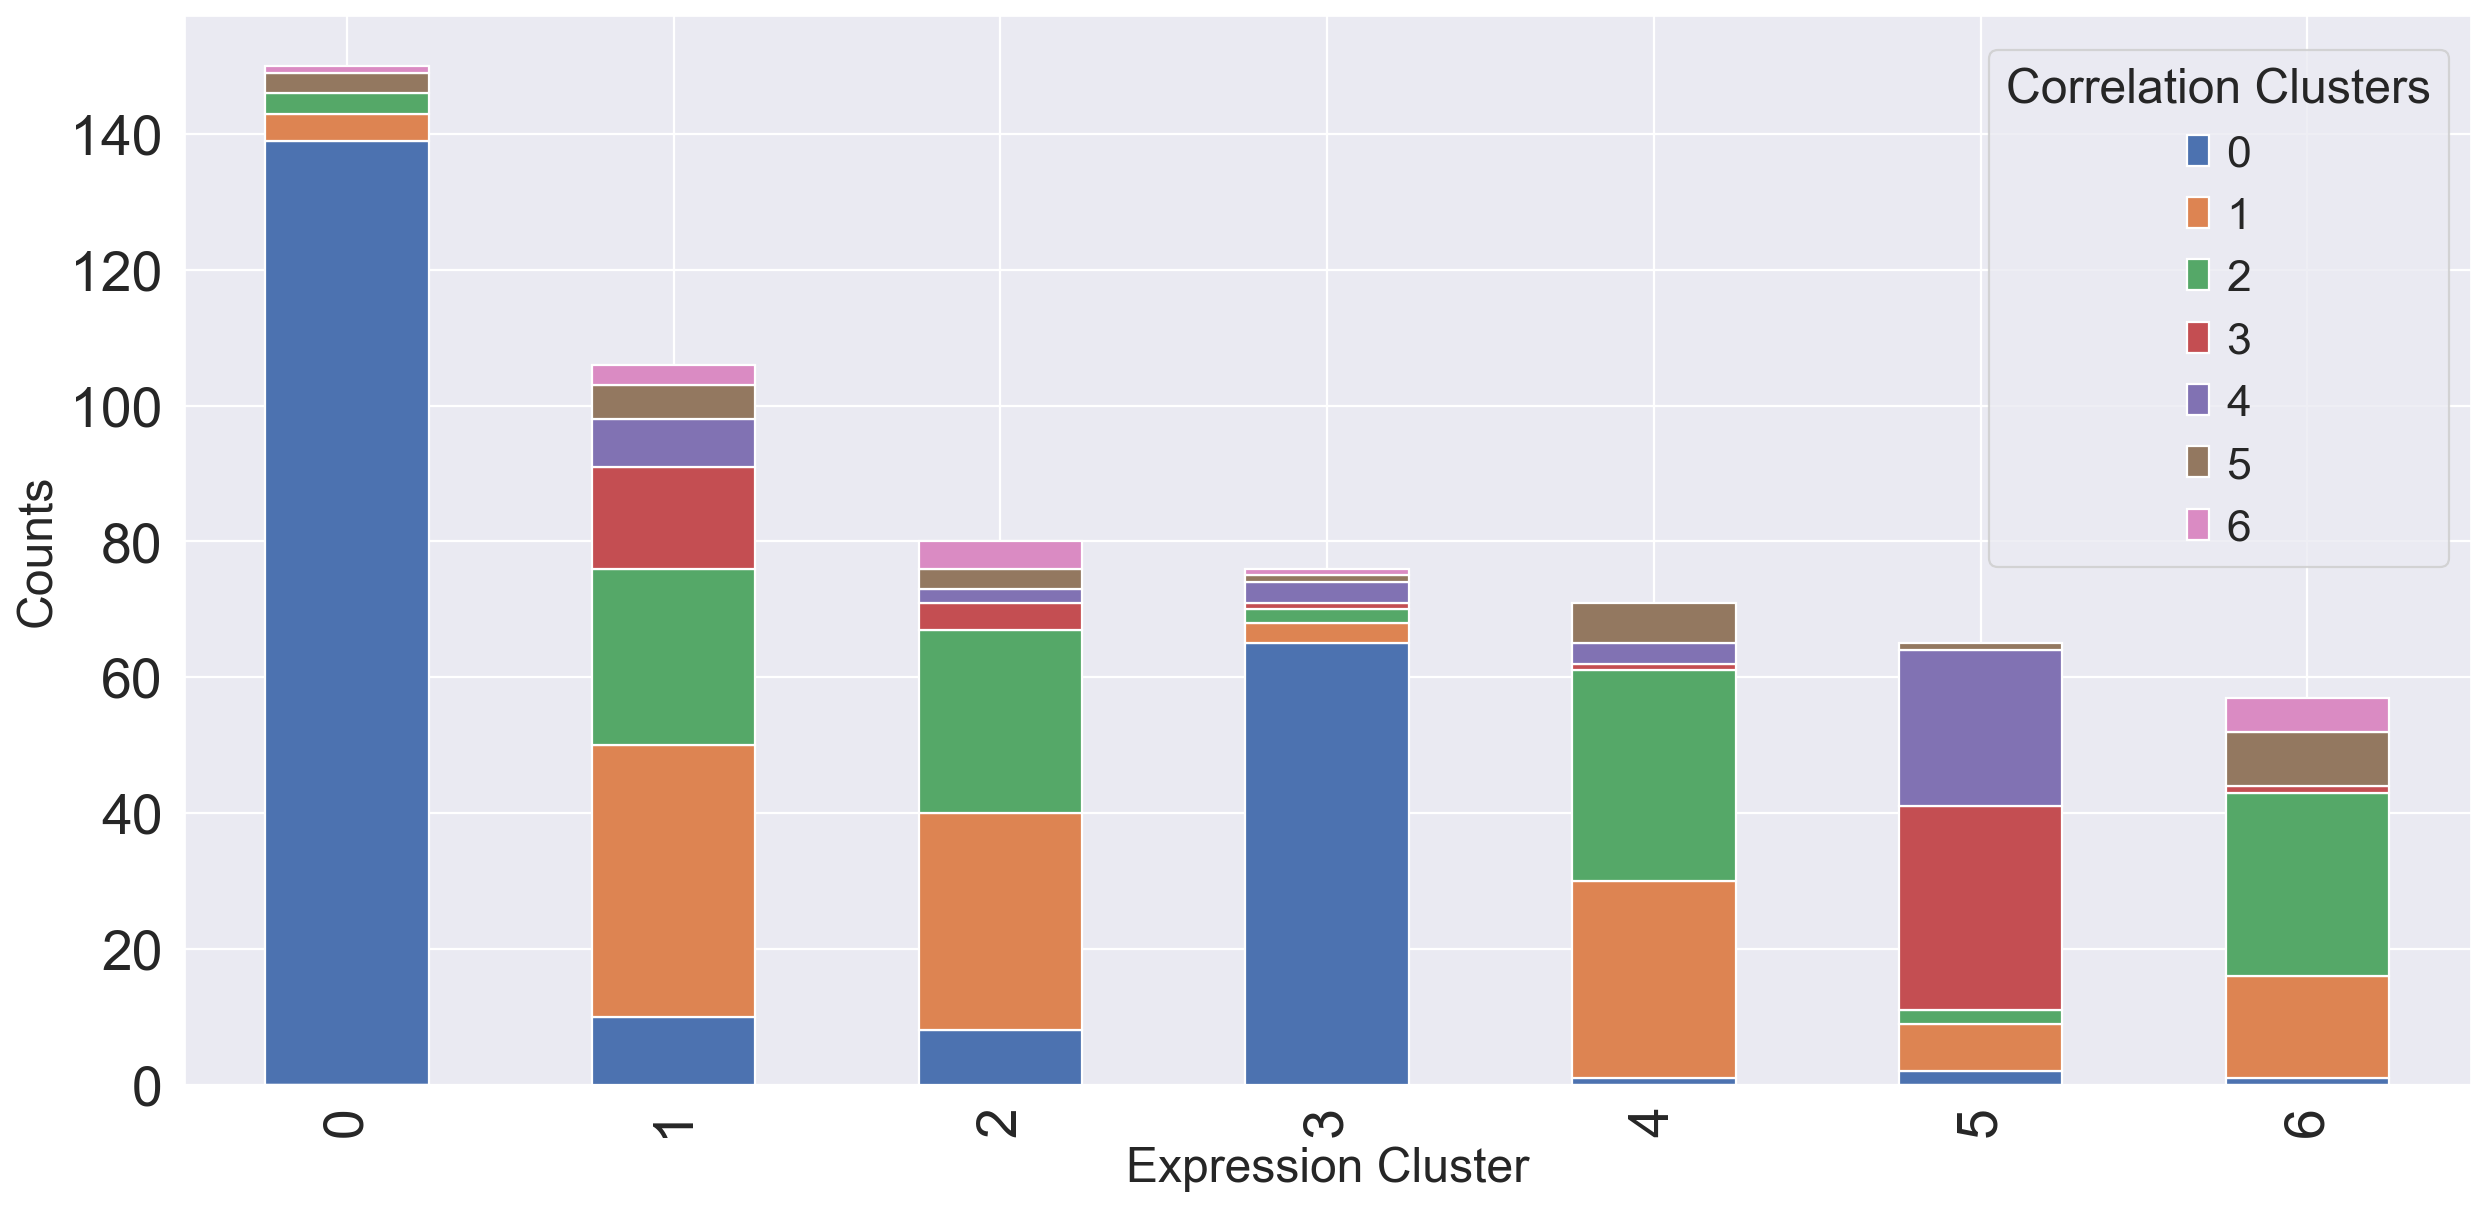

In [158]:
fig = plt.figure(figsize=(16, 8))
x_counts_df.plot.bar(stacked=True, ax=fig.gca(), xlabel='Expression Cluster', ylabel='Counts', legend=False)
fig.legend(title='Correlation Clusters', loc=1, bbox_to_anchor=(0.98,0.95), fontsize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid('off')
plt.tight_layout()
plt.savefig('coclustering barplot.png',facecolor='white')

In [121]:
np.sum(x_counts_df.values)

1210.0

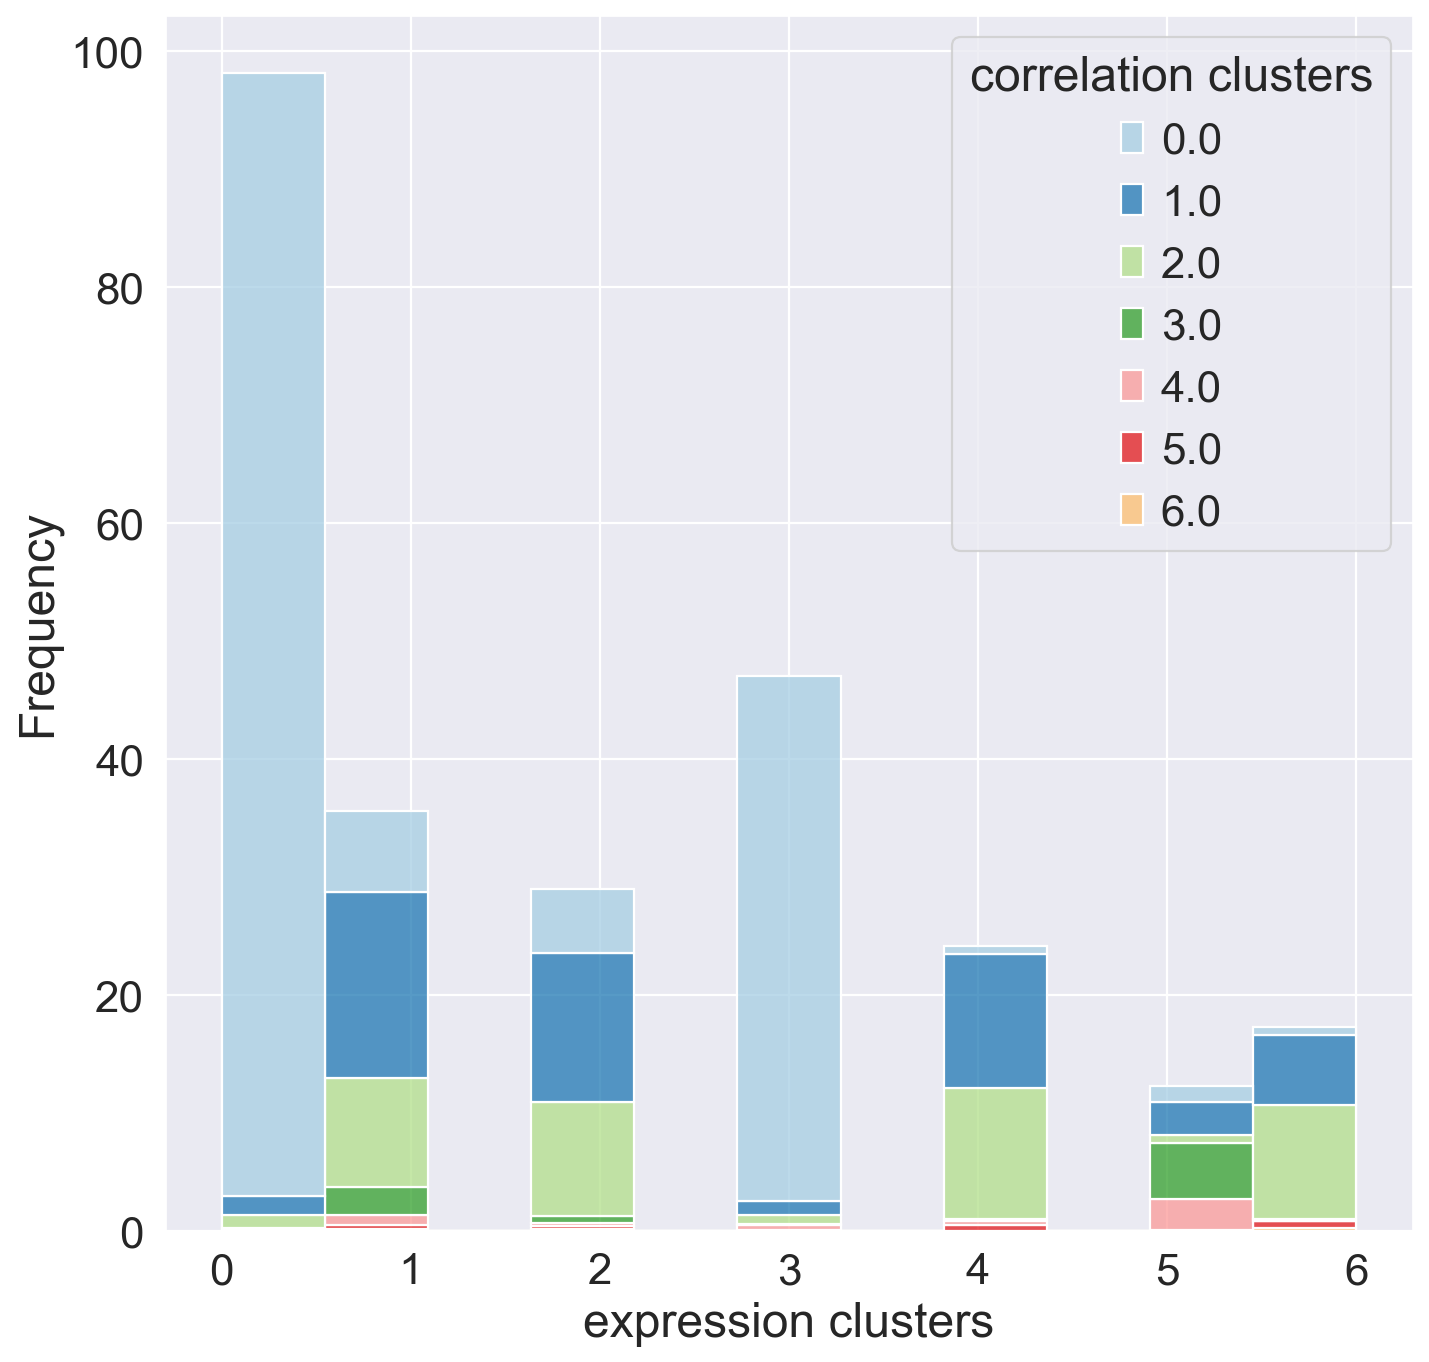

In [68]:
# sns.set(font_scale=1.8)
# ax, fig = subplot()
plt.figure(figsize=(10, 10))
g = sns.histplot(data=x, x="expression clusters", hue="correlation clusters", stat='frequency', multiple="stack", palette='Paired')

# plt.tight_layout()
# plt.savefig('.\\figures\\co clustering.png')

## Plot average correlation in clustermap per cell type

In [175]:
bm_temp = np.zeros(len(bm_corr_l))
uc_temp1 = np.zeros(len(exp1_uc_corr_l))
uc_temp2 = np.zeros(len(exp2_uc_corr_l))
hch_temp = np.zeros(len(hch_corr_l))

bm_mean = np.zeros((12,12))
uc_mean = np.zeros((12,12))
hch_mean = np.zeros((16,16))

for m in range(len(bm_corr_l[0].index.tolist())):
    for n in range(len(bm_corr_l[0].columns.tolist())):
        idx = bm_corr_l[0].index.tolist()[m]
        col = bm_corr_l[0].columns.tolist()[n]
        for i in range(len(bm_corr_l)):
            bm_temp[i] = bm_corr_l[i].loc[idx, col]
        bm_mean[m,n] = np.mean(bm_temp)
for m in range(len(exp1_uc_corr_l[0].index.tolist())):
    for n in range(len(exp1_uc_corr_l[0].columns.tolist())):
        idx = exp1_uc_corr_l[0].index.tolist()[m]
        col = exp1_uc_corr_l[0].columns.tolist()[n]
        for i in range(len(exp1_uc_corr_l)):
            uc_temp1[i] = exp1_uc_corr_l[i].loc[idx, col]
        for i in range(len(exp2_uc_corr_l)):
            uc_temp2[i] = exp2_uc_corr_l[i].loc[idx, col]
        uc_temp = np.concatenate((uc_temp1, uc_temp2))
        uc_mean[m,n] = np.mean(uc_temp)
for m in range(len(hch_corr_l[0].index.tolist())):
    for n in range(len(hch_corr_l[0].columns.tolist())):
        idx = hch_corr_l[0].index.tolist()[m]
        col = hch_corr_l[0].columns.tolist()[n]
        for i in range(len(hch_corr_l)):
            hch_temp[i] = hch_corr_l[i].loc[idx,col]
        hch_mean[m,n] = np.mean(hch_temp)

In [181]:
bm_mean_df = pd.DataFrame(bm_mean, columns=bm_corr_l[0].columns.tolist(), index=bm_corr_l[0].index.tolist())
uc_mean_df = pd.DataFrame(uc_mean, columns=exp1_uc_corr_l[0].columns.tolist(), index=exp1_uc_corr_l[0].index.tolist())
hch_mean_df = pd.DataFrame(hch_mean, columns=hch_corr_l[0].columns.tolist(), index=hch_corr_l[0].index.tolist())

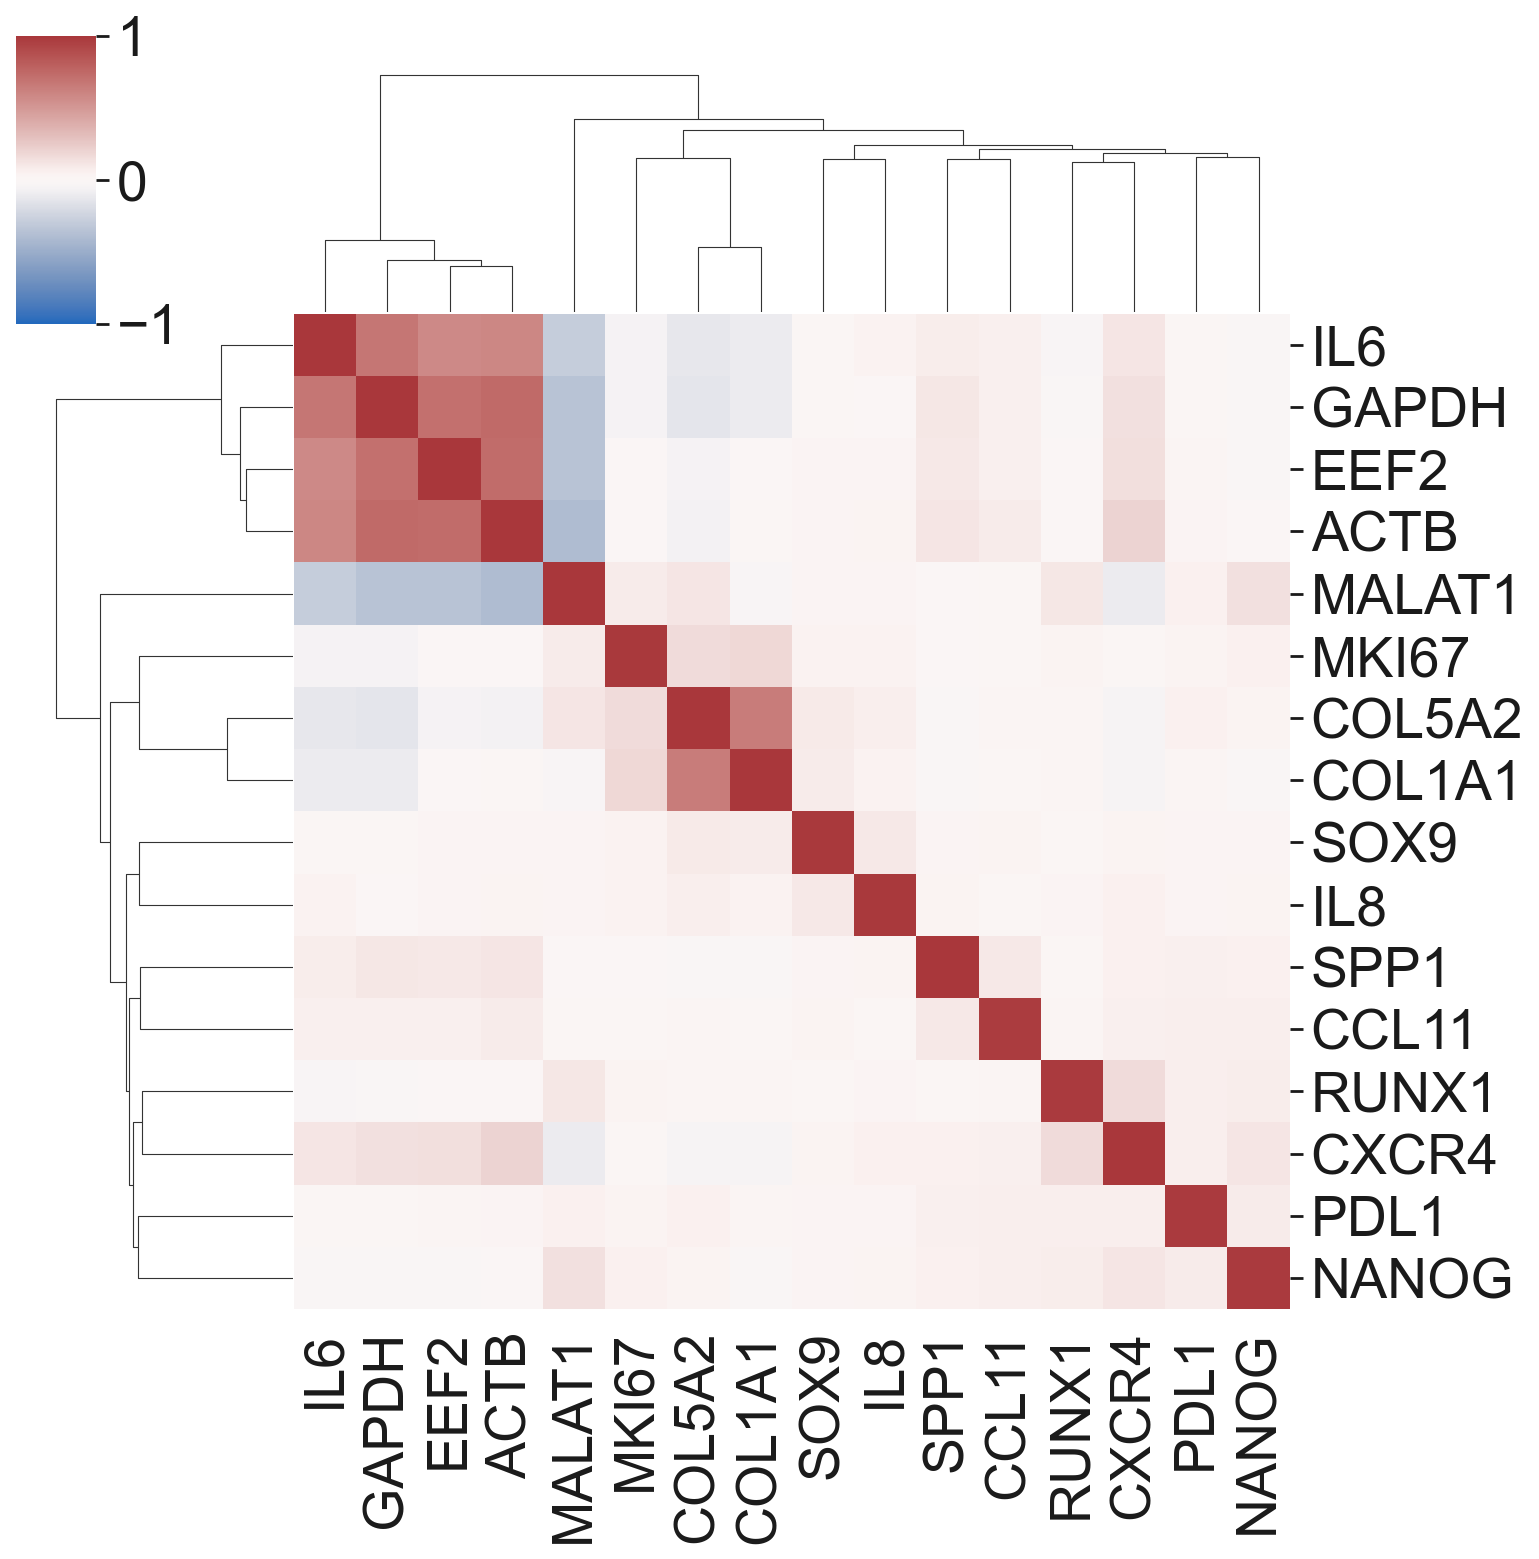

In [190]:
sns.clustermap(hch_mean_df, cmap='vlag', vmin=-1, vmax=1, xticklabels=True, yticklabels=True)
plt.savefig('hch mean correlation.png')

In [214]:
save_name = os.path.join('patch correlation clustering.h5ad')
corr_adata.write(filename=save_name)

In [73]:
adata.obs['Cell']

0        exp1_bm_001_1
1        exp1_bm_003_1
2        exp1_bm_003_2
3        exp1_bm_003_3
4        exp1_bm_004_1
            ...       
600     exp1_hch_034_6
601     exp1_hch_034_7
602     exp1_hch_034_8
603     exp1_hch_034_9
604    exp1_hch_034_10
Name: Cell, Length: 605, dtype: object